# Packages

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

nlp = spacy.load('fr_core_news_sm')


# Fonctions 

In [2]:
def display_results(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Train Precision:", precision_score(y_train, y_train_pred))
    print("Train Recall:", recall_score(y_train, y_train_pred))
    print("Test Precision:", precision_score(y_test, y_test_pred))
    print("Test Recall:", recall_score(y_test, y_test_pred))
    
    # ROC and AUC
    train_probs = model.predict_proba(X_train)[:,1]
    test_probs = model.predict_proba(X_test)[:,1]
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)
    print('Train AUC:', train_auc)
    print('Test AUC:', test_auc)
    
    train_fpr, train_tpr, _ = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_probs)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_fpr, train_tpr, label='Train AUC: {:.2f}'.format(train_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Train ROC Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_fpr, test_tpr, label='Test AUC: {:.2f}'.format(test_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test ROC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def preprocess_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized_text


# # Liste des mots en rapport à la prise de rdv
# list_mots_rdv = ["rendez-vous","rencontre","entrevue","consultation","entretien","réunion","rdv","appo","Rdv","disponibilité","créneau","horaire","date","heure"]
# def predict_proba_for_text(text, model, vectorizer, nlp):
#     # Prétraitement du texte
#     preprocessed_text = preprocess_text(text)

#     # Transformation TF-IDF
#     tfidf_features = vectorizer.transform([preprocessed_text])

#     # Prédiction avec le modèle
#     proba = model.predict_proba(tfidf_features)[0][1]  # prend la probabilité pour la classe 1
#     return proba

list_mots_rdv = ["rendez-vous","rencontre","entrevue","consultation","entretien","réunion","rdv","appo","Rdv","disponibilité","créneau","horaire","date","heure"]

def adjust_proba(proba, factor=0.2, increase=True):
    if increase:
        return proba + (1 - proba) * factor
    else:
        return proba * (1 - factor)

def contains_keyword(text, keywords):
    for word in keywords:
        if word in text:
            return True
    return False

def predict_proba_for_text(text, model, vectorizer, nlp):
    # Prétraitement du texte
    preprocessed_text = preprocess_text(text)

    # Transformation TF-IDF
    tfidf_features = vectorizer.transform([preprocessed_text])

    # Prédiction avec le modèle
    proba = model.predict_proba(tfidf_features)[0][1]  # prend la probabilité pour la classe 1

    # Ajustement de la probabilité basée sur la présence/absence de mots-clés
    if contains_keyword(preprocessed_text, list_mots_rdv):
        proba = adjust_proba(proba, increase=True)
    else:
        proba = adjust_proba(proba, increase=False)
    
    return proba



# Création des données

In [3]:
email_RDV =[
    "Cher M. Tremblay, J'espère que vous allez bien. Je souhaite prendre rendez-vous avec vous pour discuter de mes projets d'investissement et obtenir vos conseils financiers. Pourriez-vous me proposer quelques créneaux horaires disponibles la semaine prochaine ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Gagnon, Je prévois de réaliser des travaux dans ma maison et j'aimerais obtenir un prêt pour financer ce projet. Serait-il possible de planifier un rendez-vous pour que nous puissions discuter des options de prêt disponibles ?\n\nCordialement,\nMarc Dupuis",
    "Chère Mme. Martin, Je suis intéressé par les produits d'assurance que vous proposez et j'aimerais en savoir plus sur les différentes couvertures disponibles. Serait-il envisageable de se rencontrer pour en discuter plus en détail ?\n\nBien à vous,\nSophie Lambert",
    "Cher M. Leclerc, Je suis actuellement en train de planifier ma retraite et j'aurais besoin de conseils sur les meilleures stratégies de placement pour assurer ma sécurité financière. Serait-il possible de convenir d'un rendez-vous pour aborder ce sujet ?\n\nCordialement,\nÉric Tremblay",
    "Cher M. Johnson, J'ai récemment hérité d'une somme d'argent et je souhaite investir cette somme de manière judicieuse. Pourriez-vous m'accorder un rendez-vous afin que nous puissions discuter des options d'investissement appropriées ?\n\nCordialement,\nSophie Martin",
    "Chère Mme. Dubois, Je suis en train de planifier l'achat d'une voiture et j'aimerais discuter des différentes options de financement qui s'offrent à moi. Pourriez-vous me proposer un rendez-vous pour aborder ce sujet ?\n\nCordialement,\nAlexandre Lavoie",
    "Cher M. Roy, Je prévois de créer un fonds d'urgence pour faire face à d'éventuels imprévus financiers. Auriez-vous un créneau disponible la semaine prochaine pour que nous puissions en discuter ?\n\nBien à vous,\nSophie Bouchard",
    "Chère Mme. Lambert, Je suis en train de préparer ma retraite et je souhaite obtenir des conseils sur la gestion de mes placements pour assurer une source de revenus stable. Serait-il possible de convenir d'un rendez-vous pour discuter de mes options ?\n\nCordialement,\nMarc Gagnon",
    "Cher M. Dubois, J'ai récemment changé d'emploi et je souhaite revoir ma stratégie d'investissement en fonction de ma nouvelle situation financière. Serait-il possible de prendre un rendez-vous pour discuter de mes options d'investissement ?\n\nCordialement,\nSophie Lefebvre",
    "Chère Mme. Johnson, Je souhaite souscrire une assurance-vie pour protéger ma famille, mais j'ai besoin d'aide pour choisir la meilleure option. Serait-il possible de fixer un rendez-vous pour que nous puissions en discuter ?\n\nBien à vous,\nNicolas Tremblay",
    "Cher M. Lavoie, Je suis en train de préparer ma déclaration d'impôts et j'aurais besoin de conseils fiscaux pour optimiser ma situation financière. Serait-il possible de fixer un rendez-vous pour que nous puissions en discuter ?\n\nCordialement,\nSophie Gagnon",
    "Chère Mme. Dupuis, J'ai des projets de voyage à moyen terme et j'aimerais investir dans des produits financiers pour financer ces voyages. Serait-il possible de fixer un rendez-vous pour discuter des meilleures options d'investissement ?\n\nBien à vous,\nAlexandre Bouchard",
    "Cher M. Tremblay, Je souhaite diversifier mon portefeuille d'investissements et je suis à la recherche de nouvelles opportunités. Pourriez-vous me proposer un rendez-vous pour que nous puissions en discuter ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Gagnon, J'aimerais planifier ma succession et j'aurais besoin de conseils sur la meilleure façon de transmettre mon patrimoine. Serait-il envisageable de prendre un rendez-vous pour discuter de cette question ?\n\nBien à vous,\nMarc Dubois",
    "Cher M. Dupont, J'espère que vous allez bien. Je souhaiterais prendre un rendez-vous avec vous afin de discuter de ma situation financière et explorer les différentes options d'investissement. Pouvez-vous me proposer quelques créneaux horaires disponibles la semaine prochaine ?\n\nCordialement,\nMarie Dubois",
    "Chère Mme. Martin, J'ai le projet d'acquérir un bien immobilier dans un avenir proche et j'aurais besoin de vos conseils en matière de financement et de prêt hypothécaire. Pourriez-vous me consacrer un rendez-vous pour que nous puissions en discuter en détail ?\n\nBien à vous,\nLuc Dupuis",
    "Chère Mme. Garcia, Je souhaite faire le point sur mes comptes bancaires et mes investissements récents. Serait-il possible de fixer un rendez-vous cette semaine pour que vous puissiez m'apporter votre expertise sur ces sujets ?\n\nCordialement,\nThomas Leroy",
    "Cher M. Nguyen, Mon prêt immobilier arrive bientôt à échéance, et j'aimerais discuter des différentes options qui s'offrent à moi pour sa révision. Serait-il envisageable de convenir d'un rendez-vous pour que nous puissions en parler ?\n\nBien à vous,\nSophie Tremblay",
    "Cher M. Lee, Je suis à la recherche d'informations sur les opportunités de placement disponibles actuellement. Pouvez-vous m'accorder un rendez-vous afin que nous puissions en discuter de vive voix ?\n\nCordialement,\nEmily Johnson",
    "Chère Mme. Martinez, Je prévois de démarrer mon entreprise dans les prochains mois et aurais besoin de vos conseils sur les solutions de financement disponibles. Serait-il possible de fixer un rendez-vous pour en discuter de manière approfondie ?\n\nBien à vous,\nAlexandre Dupuis",
    "Cher M. Wilson, J'aimerais effectuer un bilan patrimonial afin d'évaluer ma situation financière globale et d'identifier d'éventuelles opportunités d'optimisation. Pourriez-vous me proposer un rendez-vous à cet effet ?\n\nCordialement,\nSophie Lambert",
    "Chère Mme. Anderson, Je souhaite souscrire une nouvelle assurance et aurais besoin de vos conseils pour choisir la meilleure option en fonction de ma situation. Serait-il possible de se rencontrer pour en discuter ?\n\nBien à vous,\nDavid Martin",
    "Cher M. Lopez, J'ai une question urgente concernant mon compte bancaire et je pense que cela nécessite une discussion en personne. Pourriez-vous me recevoir rapidement pour m'éclaircir sur ce point ?\n\nCordialement,\nSarah Dubois",
    "Chère Mme. Clark, Je suis actuellement intéressé par un projet important qui nécessite un prêt. J'aimerais discuter des modalités de ce prêt et des documents nécessaires pour constituer mon dossier. Serait-il possible de se rencontrer à votre convenance ?\n\nBien à vous,\nThomas Roy",
    "Cher M. Lefebvre, J'aimerais planifier une réunion pour discuter de mes investissements et de mes objectifs financiers. Serait-il possible de convenir d'un rendez-vous cette semaine ?\n\nCordialement,\nSophie Martin",
    "Chère Mme. Roy, Je prévois de faire des travaux de rénovation dans ma maison et aurais besoin de financement. Pourriez-vous me proposer un rendez-vous pour discuter des options de prêt disponibles ?\n\nBien à vous,\nMarc Gagnon",
    "Cher M. Bergeron, Je suis en train de revoir ma stratégie d'épargne en vue de ma retraite. Serait-il possible de prendre un rendez-vous pour discuter des meilleures options d'investissement ?\n\nCordialement,\nSophie Dupuis",
    "Chère Mme. Tremblay, Je suis à la recherche d'une assurance santé et aurais besoin de conseils sur les différentes options qui s'offrent à moi. Serait-il possible de se rencontrer pour en discuter ?\n\nBien à vous,\nThomas Leclerc",
    "Cher M. Martin, J'ai récemment reçu une somme d'argent et je souhaite investir dans l'immobilier. Pourriez-vous me proposer un rendez-vous pour discuter des opportunités disponibles ?\n\nCordialement,\nSophie Gagnon",
    "Chère Mme. Dubois, Je prévois de créer un fonds d'urgence et aurais besoin de conseils financiers pour optimiser ma gestion budgétaire. Serait-il possible de fixer un rendez-vous pour en discuter ?\n\nBien à vous,\nAlexandre Lambert",
    "Cher M. Bouchard, J'aimerais souscrire une assurance-vie pour protéger ma famille en cas de décès. Serait-il envisageable de prendre un rendez-vous pour discuter des différentes options d'assurance ?\n\nCordialement,\nSophie Martin",
    "Chère Mme. Gagnon, Je suis en train de planifier un voyage à l'étranger et aurais besoin de conseils sur les solutions de change de devises. Pourriez-vous me consacrer un rendez-vous pour aborder ce sujet ?\n\nBien à vous,\nMarc Dupuis",
    "Cher M. Lavoie, Je souhaite ouvrir un compte d'épargne pour mon enfant et j'aimerais discuter des meilleures options bancaires. Serait-il possible de fixer un rendez-vous pour en discuter ?\n\nCordialement,\nSophie Bouchard",
    "Chère Mme. Martin, Je suis en train de préparer ma retraite et aurais besoin de conseils pour optimiser ma protection sociale. Serait-il possible de convenir d'un rendez-vous pour en discuter ?\n\nBien à vous,\nAlexandre Dubois",
    "Cher M. Gagnon, Je souhaite investir dans des actions et aurais besoin de conseils sur les meilleures opportunités du moment. Serait-il possible de prendre un rendez-vous pour en discuter ?\n\nCordialement,\nSophie Tremblay",
    "Chère Mme. Lambert, Je prévois d'acheter une maison et j'aimerais obtenir des informations sur les taux de prêt hypothécaire. Pourriez-vous me proposer un rendez-vous pour aborder ce sujet ?\n\nBien à vous,\nMarc Martin",
    "Cher M. Dupuis, Je suis en train de planifier un voyage à l'étranger et j'aurais besoin de conseils sur les solutions de change de devises. Serait-il possible de se rencontrer pour en discuter ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Leclerc, J'ai l'intention de commencer à investir dans le marché boursier et aurais besoin de conseils sur les meilleures actions à acheter. Serait-il possible de fixer un rendez-vous pour en discuter ?\n\nBien à vous,\nAlexandre Tremblay",
    "Cher M. Bergeron, Je souhaite revoir ma stratégie d'investissement pour mieux préparer l'avenir de mes enfants. Serait-il envisageable de prendre un rendez-vous pour discuter des options d'investissement ?\n\nCordialement,\nSophie Martin",
    "Cher M. Lambert, Je suis en train de préparer ma déclaration d'impôts et aurais besoin de conseils fiscaux pour optimiser ma situation financière. Serait-il possible de fixer un rendez-vous pour que nous puissions en discuter ?\n\nCordialement,\nSophie Gagnon",
    "Chère Mme. Dupuis, J'ai des projets de voyage à moyen terme et j'aimerais investir dans des produits financiers pour financer ces voyages. Serait-il possible de fixer un rendez-vous pour discuter des meilleures options d'investissement ?\n\nBien à vous,\nAlexandre Bouchard",
    "Cher M. Tremblay, Je souhaite diversifier mon portefeuille d'investissements et je suis à la recherche de nouvelles opportunités. Pourriez-vous me proposer un rendez-vous pour que nous puissions en discuter ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Gagnon, J'aimerais planifier ma succession et j'aurais besoin de conseils sur la meilleure façon de transmettre mon patrimoine. Serait-il envisageable de prendre un rendez-vous pour discuter de cette question ?\n\nBien à vous,\nMarc Dubois",
    "Cher M. Dupont, J'espère que vous allez bien. Je souhaiterais prendre un rendez-vous avec vous afin de discuter de ma situation financière et explorer les différentes options d'investissement. Pouvez-vous me proposer quelques créneaux horaires disponibles la semaine prochaine ?\n\nCordialement,\nMarie Dubois",
    "Chère Mme. Martin, J'ai le projet d'acquérir un bien immobilier dans un avenir proche et j'aurais besoin de vos conseils en matière de financement et de prêt hypothécaire. Pourriez-vous me consacrer un rendez-vous pour que nous puissions en discuter en détail ?\n\nBien à vous,\nLuc Dupuis",
    "Chère Mme. Garcia, Je souhaite faire le point sur mes comptes bancaires et mes investissements récents. Serait-il possible de fixer un rendez-vous cette semaine pour que vous puissiez m'apporter votre expertise sur ces sujets ?\n\nCordialement,\nThomas Leroy",
    "Cher M. Nguyen, Mon prêt immobilier arrive bientôt à échéance, et j'aimerais discuter des différentes options qui s'offrent à moi pour sa révision. Serait-il envisageable de convenir d'un rendez-vous pour que nous puissions en parler ?\n\nBien à vous,\nSophie Tremblay",
    "Cher M. Lee, Je suis à la recherche d'informations sur les opportunités de placement disponibles actuellement. Pouvez-vous m'accorder un rendez-vous afin que nous puissions en discuter de vive voix ?\n\nCordialement,\nEmily Johnson",
    "Chère Mme. Martinez, Je prévois de démarrer mon entreprise dans les prochains mois et aurais besoin de vos conseils sur les solutions de financement disponibles. Serait-il possible de fixer un rendez-vous pour en discuter de manière approfondie ?\n\nBien à vous,\nAlexandre Dupuis",
    "Cher M. Wilson, J'aimerais effectuer un bilan patrimonial afin d'évaluer ma situation financière globale et d'identifier d'éventuelles opportunités d'optimisation. Pourriez-vous me proposer un rendez-vous à cet effet ?\n\nCordialement,\nSophie Lambert",
    "Chère Mme. Anderson, Je souhaite souscrire une nouvelle assurance et aurais besoin de vos conseils pour choisir la meilleure option en fonction de ma situation. Serait-il possible de se rencontrer pour en discuter ?\n\nBien à vous,\nDavid Martin",
    "Cher M. Lopez, J'ai une question urgente concernant mon compte bancaire et je pense que cela nécessite une discussion en personne. Pourriez-vous me recevoir rapidement pour m'éclaircir sur ce point ?\n\nCordialement,\nSarah Dubois",
    "Chère Mme. Clark, Je suis actuellement intéressé par un projet important qui nécessite un prêt. J'aimerais discuter des modalités de ce prêt et des documents nécessaires pour constituer mon dossier. Serait-il possible de se rencontrer à votre convenance ?\n\nBien à vous,\nThomas Roy",
    "Cher M. Bouchard, J'espère que vous allez bien. Je souhaiterais prendre un rendez-vous avec vous afin de discuter de ma situation financière et explorer les différentes options d'investissement. Pouvez-vous me proposer quelques créneaux horaires disponibles la semaine prochaine ?\n\nCordialement,\nMarie Dubois",
    "Chère Mme. Tremblay, Je prévois de faire des travaux de rénovation dans ma maison et aurais besoin de financement. Pourriez-vous me proposer un rendez-vous pour discuter des options de prêt disponibles ?\n\nBien à vous,\nMarc Gagnon",
     "Cher M. Roy, Je souhaite créer un plan financier pour atteindre mes objectifs d'épargne à long terme. Serait-il possible de prendre un rendez-vous pour que nous puissions discuter de ma stratégie financière ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Côté, Je suis en train de planifier l'achat d'une propriété et aurais besoin de conseils sur les options de financement disponibles. Pourriez-vous me proposer un rendez-vous pour en discuter en détail ?\n\nBien à vous,\nMarc Dupuis",
    "Chère Mme. Bergeron, Je suis intéressé par les produits d'investissement que vous offrez et j'aimerais en savoir plus sur les rendements potentiels. Serait-il envisageable de se rencontrer pour discuter de mes options d'investissement ?\n\nCordialement,\nSophie Lambert",
    "Cher M. Tremblay, J'aimerais planifier ma retraite et j'aurais besoin de conseils sur la meilleure façon de gérer mes fonds de pension. Serait-il possible de convenir d'un rendez-vous pour discuter de cette question ?\n\nBien à vous,\nÉric Tremblay",
    "Cher M. Johnson, Je souhaite optimiser ma stratégie fiscale et aurais besoin de conseils sur les déductions et crédits d'impôt disponibles. Serait-il possible de fixer un rendez-vous pour en discuter ?\n\nCordialement,\nSophie Martin",
    "Chère Mme. Dubois, Je suis en train de planifier un voyage à l'étranger et j'aimerais en savoir plus sur les options d'assurance voyage. Pourriez-vous me proposer un rendez-vous pour discuter de mes besoins en assurance ?\n\nBien à vous,\nAlexandre Lavoie",
    "Cher M. Bouchard, J'ai récemment hérité d'une somme d'argent et j'aimerais investir de manière responsable. Serait-il possible de m'accorder un rendez-vous pour discuter des investissements socialement responsables ?\n\nCordialement,\nSophie Bouchard",
    "Chère Mme. Gagnon, Je suis en train de préparer mon budget familial et aurais besoin de conseils sur la gestion de mes finances personnelles. Serait-il envisageable de convenir d'un rendez-vous pour discuter de ma situation financière ?\n\nBien à vous,\nMarc Gagnon",
    "Cher M. Dupuis, J'aimerais obtenir un prêt personnel pour financer un projet personnel. Serait-il possible de fixer un rendez-vous pour discuter des options de prêt qui s'offrent à moi ?\n\nCordialement,\nSophie Lefebvre",
    "Chère Mme. Johnson, Je suis en train de planifier un mariage et j'aurais besoin de conseils sur les options de financement pour cet événement. Pourriez-vous me proposer un rendez-vous pour discuter de mes projets financiers liés au mariage ?\n\nBien à vous,\nNicolas Tremblay",
    "Cher M. Lavoie, Je suis en train de réorganiser mes investissements et j'aimerais en savoir plus sur les produits financiers disponibles. Serait-il envisageable de se rencontrer pour discuter de mes besoins en investissement ?\n\nCordialement,\nSophie Gagnon",
    "Chère Mme. Dupuis, Je souhaite souscrire une assurance habitation pour protéger ma maison. Serait-il possible de fixer un rendez-vous pour discuter des différentes options d'assurance ?\n\nBien à vous,\nAlexandre Bouchard",
    "Cher M. Tremblay, Je prévois de réaliser des travaux de rénovation dans ma maison et j'aurais besoin de financement. Serait-il possible de prendre un rendez-vous pour discuter des options de prêt qui s'offrent à moi ?\n\nCordialement,\nSophie Lavoie",
    "Chère Mme. Gagnon, Je suis en train de préparer ma déclaration d'impôts et j'aurais besoin de conseils fiscaux pour optimiser ma situation financière. Serait-il envisageable de convenir d'un rendez-vous pour discuter de mes finances ?\n\nBien à vous,\nMarc Dupuis",
    "Chère Mme. Martin, Je souhaite investir dans des actions en bourse et aurais besoin de conseils sur les meilleures opportunités d'investissement. Serait-il possible de fixer un rendez-vous pour en discuter ?\n\nCordialement,\nSophie Lambert",
    "Cher M. Leclerc, J'aimerais planifier ma retraite anticipée et j'aurais besoin de conseils sur la gestion de mon épargne. Serait-il envisageable de se rencontrer pour discuter de mes options de retraite ?\n\nBien à vous,\nÉric Tremblay"
    ]

email_Doc_bulletin = [
    "Cher Monsieur Carter,\n\nJ'espère que vous allez bien. Je vous adresse mon dernier bulletin de salaire pour que vous puissiez mettre à jour mes informations financières.\n\nCordialement,\nDavid Johnson",
    "Chère Madame Reynolds,\n\nJ'espère que vous allez bien. Je joins à ce courriel mon dernier bulletin de salaire. J'aimerais attirer votre attention sur quelques points importants de ce document, notamment mes revenus mensuels et les déductions en cours.\n\nN'hésitez pas à me contacter si vous avez besoin de plus amples informations.\n\nCordialement,\nSarah Martinez",
    "Cher Monsieur Patel,\n\nJ'espère que cette journée vous trouve en bonne forme. Je vous envoie mon dernier bulletin de salaire afin que vous puissiez avoir une vue à jour de ma situation financière. J'aimerais également profiter de cette occasion pour solliciter vos conseils sur la meilleure manière de gérer ces revenus.\n\nJe suis disponible pour discuter de ces aspects à votre convenance.\n\nCordialement,\nMichael Wang",
    "Chère Madame Ng,\n\nJe vous adresse mon dernier bulletin de salaire pour mettre à jour mon dossier. Merci de bien vouloir enregistrer ces informations dans mes données bancaires.\n\nN'hésitez pas à me faire savoir si vous avez besoin d'autres documents ou informations.\n\nCordialement,\nEmily Rodriguez",
    "Cher Monsieur Smith,\n\nJ'espère que vous allez bien. Je tenais à confirmer la réception de mon dernier bulletin de salaire que je vous ai transmis par courriel précédent. Merci de m'indiquer dès que ces informations auront été intégrées à mon dossier.\n\nRestant à votre disposition pour toute question.\n\nCordialement,\nThomas Müller",
    "Chère Madame Martin,\n\nJe vous envoie mon dernier bulletin de salaire en préparation de notre prochain rendez-vous. J'aimerais discuter avec vous de la meilleure manière d'optimiser ma situation financière en tenant compte de ces nouvelles informations.\n\nJ'attends avec impatience notre rencontre.\n\nCordialement,\nOlivia Kim",
    "Cher Monsieur Fernandez,\n\nJ'espère que tout va bien de votre côté. Je vous adresse mon dernier bulletin de salaire pour vérification. Si vous remarquez des incohérences ou si vous avez des suggestions pour améliorer ma gestion financière, je serais ravi de les entendre.\n\nMerci pour votre attention.\n\nCordialement,\nRobert Fernandez",
    "Chère Madame Ali,\n\nComme convenu, je vous envoie mon dernier bulletin de salaire pour la mise à jour mensuelle de mes informations financières. Je vous remercie de bien vouloir tenir compte de ces chiffres dans l'évaluation de ma situation.\n\nJe reste à votre disposition pour toute question ou clarification.\n\nCordialement,\nEmma Ali",
    "Cher Monsieur González,\n\nJe joins mon dernier bulletin de salaire dans le cadre du projet \"Achat Maison\" que nous avons discuté lors de notre dernier entretien. Ces informations devraient aider à déterminer la faisabilité du projet.\n\nJe suis ouvert à toute suggestion ou observation que vous pourriez avoir.\n\nCordialement,\nDaniel Lopez",
    "Chère Madame Schneider,\n\nJe fais suite à notre récente conversation et je vous envoie mon dernier bulletin de salaire comme convenu. Veuillez le trouver en pièce jointe.\n\nJe reste à votre disposition pour avancer sur les points que nous avons discutés.\n\nCordialement,\nSophia García"
]

email_Doc_bulletin2 = [
    "Madame, Monsieur, Je vous contacte au nom de [nom de l'entreprise] pour demander un devis pour les travaux suivants : * [Liste des travaux] Pourriez-vous me faire parvenir un devis détaillé dans les meilleurs délais ? Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je vous contacte pour obtenir des informations sur [objet de la demande]. Je souhaiterais en savoir plus sur les points suivants : * [Liste des questions] Je vous remercie de votre réponse. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je vous adresse le rapport d'activité du mois de [mois]. Ce rapport présente les activités suivantes : * [Liste des activités] Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je vous adresse les documents suivants : * [Liste des documents] Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je vous contacte pour demander une modification du contrat [numéro du contrat]. Je souhaite modifier les points suivants : * [Liste des modifications] Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je suis contraint d'annuler notre rendez-vous du [date du rendez-vous]. Je vous propose de reprogrammer ce rendez-vous à une date ultérieure. Je vous remercie de votre compréhension. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je vous contacte pour demander un remboursement de la facture [numéro de la facture]. Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je suis client de votre entreprise depuis [nombre] années et je suis très satisfait de vos services. Je tenais à vous recommander auprès de mes contacts. Je vous remercie de votre attention. Cordialement, [Votre nom]",
    "Madame, Monsieur, Je suis client de votre entreprise depuis [nombre] années et je suis très satisfait de vos services. Je tenais à témoigner de mon expérience positive. Je vous remercie de votre attention. Cordialement, [Votre nom]",
]


email_Doc_bulletin3 = [
    "Salut [nom de la personne], Je sais que tu es fan de [objet de l'invitation], alors je voulais te proposer de venir avec moi au [événement]. Ça serait cool de passer un moment ensemble. Qu'en dis-tu ? À bientôt, [Ton nom]",
    "Salut [nom de la personne], Je viens d'apprendre que tu as [nouvelle]. Je suis super content pour toi ! Félicitations encore ! À bientôt, [Ton nom]",
    "Salut [nom de la personne], Je sais que tu es en train de passer une période difficile. Je suis là pour toi si tu as besoin de parler. Tu es une personne forte et courageuse, et je suis sûr que tu vas surmonter cette épreuve. Force et courage, [Ton nom]",
    "Salut [nom de la personne], Je voulais te remercier pour [chose pour laquelle tu remercies]. C'était vraiment super de ta part. Je suis très reconnaissant. À bientôt, [Ton nom]",
    "Salut [nom de la personne], Je sais que tu es en train de [travailler sur quelque chose], et je voulais te proposer mon aide. Je suis disponible si tu as besoin de quelque chose. À bientôt, [Ton nom]",
    "Salut [nom de la personne],J'ai vu que tu avais posté une annonce pour [objet de l'annonce]. Je suis intéressé par [objet de l'annonce].Est-ce que tu pourrais me donner plus d'informations ?À bientôt,"]


email_Doc_bulletin = email_Doc_bulletin + email_Doc_bulletin2 + email_Doc_bulletin3

emails = (email_RDV+email_Doc_bulletin)


In [4]:
def prep_target(email_class1,email_class0):
  return(np.repeat(1,len(email_class1)).tolist()+np.repeat(0,len(email_class0)).tolist())

list_resultat = prep_target(email_RDV,email_Doc_bulletin)

In [5]:
data  = pd.DataFrame(columns=["texte","flag"])
data["texte"]=emails
data["flag"]=list_resultat

In [6]:
data.head(2)

,texte,flag
0,"Cher M. Tremblay, J'espère que vous allez bien...",1
1,"Chère Mme. Gagnon, Je prévois de réaliser des ...",1


# Prétraitement du texte

In [7]:
data['cleaned_text'] = data['texte'].apply(preprocess_text)

# Transformer le texte en utilisant TFIDF:


In [8]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(data['cleaned_text'])
y = data['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
print(len(email_Doc_bulletin)/(len(email_RDV)+len(email_Doc_bulletin)))

0.2604166666666667


In [10]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2,3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = GridSearchCV(RandomForestClassifier(class_weight={0:4,1:1}), param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
clf.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight={0: 4, 1: 1}),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy', verbose=2)

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

clf_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
clf_gbc.fit(X_train, y_train)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 3], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

In [12]:
clf.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

# Affichage des résultats

Train Precision: 1.0
Train Recall: 0.9824561403508771
Test Precision: 1.0
Test Recall: 0.9285714285714286
Train AUC: 1.0
Test AUC: 1.0


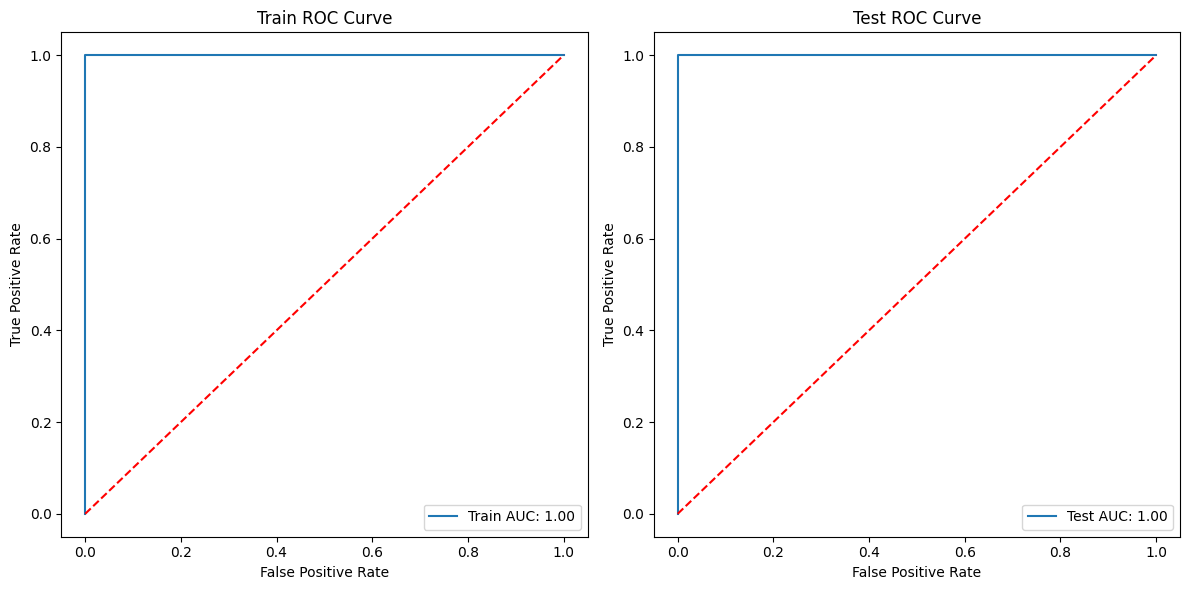

In [13]:
display_results(clf.best_estimator_, X_train, y_train, X_test, y_test)

Train Precision: 1.0
Train Recall: 1.0
Test Precision: 1.0
Test Recall: 1.0
Train AUC: 1.0
Test AUC: 1.0


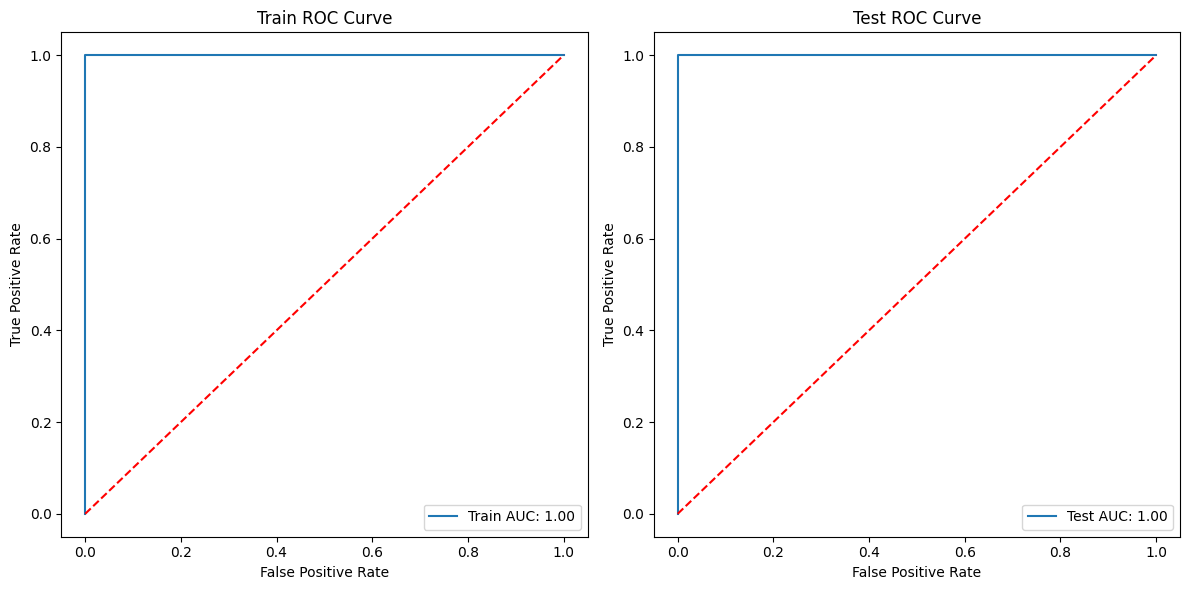

In [14]:
display_results(clf_gbc.best_estimator_, X_train, y_train, X_test, y_test)

In [18]:
# Exemple d'utilisation
text_sample = "Cher Monsieur Carter,\n\nJ'espère que vous allez bien. Je vous adresse mon dernier bulletin de salaire pour que vous puissiez mettre à jour mes informations financières.\n\nCordialement,\nDavid Johnson"
predicted_proba = predict_proba_for_text(text_sample, clf.best_estimator_, tfidf_vectorizer, nlp)
print(f"Probabilité que le texte soit classé comme '1' : {predicted_proba:.2f}")

Probabilité que le texte soit classé comme '1' : 0.22


In [19]:
# Exemple d'utilisation
text_sample = "je souhaite faire une prise de rendez-vous"
predicted_proba = predict_proba_for_text(text_sample, clf.best_estimator_, tfidf_vectorizer, nlp)
print(f"Probabilité que le texte soit classé comme '1' : {predicted_proba:.2f}")

Probabilité que le texte soit classé comme '1' : 0.58


In [20]:
# Exemple d'utilisation
text_sample = "je veux "
predicted_proba = predict_proba_for_text(text_sample, clf.best_estimator_, tfidf_vectorizer, nlp)
print(f"Probabilité que le texte soit classé comme '1' : {predicted_proba:.2f}")

Probabilité que le texte soit classé comme '1' : 0.28


## Ecriture du modèle

In [22]:
from joblib import dump

# Sauvegarde du meilleur modèle
best_model = clf_gbc.best_estimator_
dump(best_model, 'best_gradient_boosting_model.joblib')

['best_gradient_boosting_model.joblib']

In [23]:
# Sauvegarde du meilleur modèle
best_model = clf.best_estimator_
dump(best_model, 'best_rf_model.joblib')

['best_rf_model.joblib']

In [57]:

dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']